In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.tokenize import WordPunctTokenizer

In [3]:
from collections import Counter

In [4]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv("db/mathematics-articles.csv")[:10000]
tokenizer = WordPunctTokenizer()
df['tokens'] = df['article_name'].apply(lambda x: tokenizer.tokenize(x.lower()))

In [6]:
df['n_tokens'] = df['tokens'].apply(len)

In [7]:
max_length = 25
df = df.loc[df['n_tokens'] <= max_length].reset_index(drop=True)

In [8]:
all_tokens = np.sum(np.array(df['tokens'].tolist()))

In [9]:
freq = Counter(all_tokens)

In [10]:
n_tokens = 10000

In [11]:
top_tokens = dict(freq.most_common(n_tokens))

In [12]:
tokens =  ['<sos>', '<eos>', '<pad>', '<unk>'] + list(top_tokens.keys())
token2idx = {token: i for i, token in enumerate(tokens)}
idx2token = {i: token for token, i in token2idx.items()}

In [13]:
def tokenize(x):
    padding = [token2idx['<pad>']] * (max_length - len(x))
    def if_unk(token):
        return token if token in token2idx else '<unk>'
    return [token2idx[if_unk(token)] for token in ['<sos>'] + x[:max_length]] + padding + [token2idx['<eos>']]

data = np.array(df['tokens'].apply(lambda x: np.array(tokenize(x))).tolist())

In [14]:
def get_batch(X, batch_size):
    idx = np.random.choice(X.shape[0], size=batch_size)
    return X[idx]

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
device

'cpu'

In [17]:
RNN_NUM_UNITS = 64
EMB_SIZE = 100
BATCH_SIZE = 64
NUM_TOKENS = len(tokens)
N_LAYERS = 3

class MyRNN(nn.Module):
    def __init__(self, 
                 input_size=NUM_TOKENS, 
                 output_size=NUM_TOKENS,
                 emb_size=EMB_SIZE, 
                 rnn_num_units=RNN_NUM_UNITS,
                 n_layers=N_LAYERS, 
                 use_ohe=False):
        super(self.__class__, self).__init__()
        self.rnn_num_units = rnn_num_units
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        if use_ohe:
            self.emb = nn.Embedding(input_size, input_size)
            self.emb.weight.data = torch.eye(input_size)
            emb_size = input_size
        else:
            self.emb = nn.Embedding(input_size, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(rnn_num_units, output_size)
        
    def forward(self, x):
        emb = self.emb(x)
        out, _ = self.rnn(emb)
        logits = self.fc(out)
        logp = F.log_softmax(logits, dim=-1)
        return logp

In [24]:
rnn = MyRNN(use_ohe=False).to(device)
opt = torch.optim.Adam(rnn.parameters(), lr=0.01)
history = []
criterion = nn.CrossEntropyLoss()

In [25]:
rnn

MyRNN(
  (emb): Embedding(10004, 100)
  (rnn): LSTM(100, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=10004, bias=True)
)

In [38]:
batch = torch.Tensor(get_batch(data, 10)).long()

logp_seq = rnn(batch.to(device))

loss = criterion(logp_seq[:, :-1].contiguous().view(-1, len(tokens)).to(device),
                 batch[:, 1:].contiguous().view(-1).to(device))

loss.backward()
loss

tensor(1.7675, grad_fn=<NllLossBackward>)

In [45]:
print(logp_seq.shape)
print(logp_seq[:, :-1].contiguous().view(-1, len(tokens)).shape)
logp_seq.contiguous().view(-1, len(tokens)).shape

torch.Size([10, 27, 10004])
torch.Size([260, 10004])


torch.Size([270, 10004])

In [27]:
from tqdm import tqdm

In [28]:
epochs = 20
batch_size = 128
history = []

for e in range(epochs):
    num_it = len(data) // batch_size
    train_loss = 0.
    
    for it in tqdm(range(num_it)):
        batch = torch.Tensor(get_batch(data, batch_size)).long()
        batch = batch.to(device)
        
        opt.zero_grad()
        
        out = rnn(batch)
        
        loss = criterion(
            out[:, :-1].contiguous().view(-1, len(tokens)), 
            batch[:, 1:].contiguous().view(-1))
        
        loss.backward()
        
        train_loss += loss.item()
        opt.step()
        
    history.append(train_loss / len(data))

100%|██████████| 77/77 [01:03<00:00,  1.21it/s]


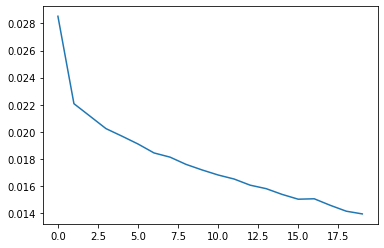

In [29]:
import matplotlib.pyplot as plt
plt.plot(history)

In [30]:
def predict_next_token(model, word: str, temperature=1.0):
    tensor = torch.Tensor([[token2idx[word]]]).long().to(device)
    out = model(tensor)[0][-1]
    # sample
    softmax = F.softmax(out / temperature, dim=-1)
    next_ix = np.random.choice(len(tokens), p=softmax.data.cpu().numpy())
    return idx2token[next_ix]

In [36]:
def generate_sentence(model, seed: str, temperature=1.0):
    next_token = predict_next_token(model, seed, temperature)
    sentence = [seed, next_token]
    while next_token not in ('<eos>', '<pad>') and len(sentence) <= max_length:
        next_token = predict_next_token(model, next_token, temperature)
        sentence.append(next_token)
    return list(filter(lambda x: x not in ['<sos>', '<pad>', '<unk>', '<eos>'], sentence))

In [37]:
generate_sentence(rnn, '<sos>')

['термодинамический',
 'о',
 'ограниченных',
 'линейные',
 'поимке',
 'к',
 'о',
 'технологических',
 'и',
 'о',
 'калибровочно',
 'анализ',
 'симметричных',
 'задачи',
 'инженерных',
 'трендом',
 'особенности',
 'классификация']

In [69]:
torch.save(rnn, "rnn.pt")

In [21]:
import torch
rnn = torch.load("rnn.pt", map_location=torch.device('cpu'))

In [ ]:
import time
while True:
    time.sleep(1)

In [3]:
from transformer import TransformerModel

In [36]:
ntokens = len(tokens) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

In [37]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

In [46]:
src_mask = model.generate_square_subsequent_mask(batch_size).to(device)

In [47]:
src_mask.shape

torch.Size([128, 128])

In [48]:
epochs = 20
batch_size = 128
history = []

for e in range(epochs):
    num_it = len(data) // batch_size
    train_loss = 0.
    
    for it in tqdm(range(num_it)):
        batch = torch.Tensor(get_batch(data, batch_size)).long()
        batch = batch.to(device)
        
        opt.zero_grad()
        
        out = model(batch, src_mask)
        
        loss = criterion(
            out[:, :-1].contiguous().view(-1, len(tokens)), 
            batch[:, 1:].contiguous().view(-1))
        
        loss.backward()
        
        train_loss += loss.item()
        opt.step()
        
    history.append(train_loss / len(data))

100%|██████████| 77/77 [02:02<00:00,  1.59s/it]


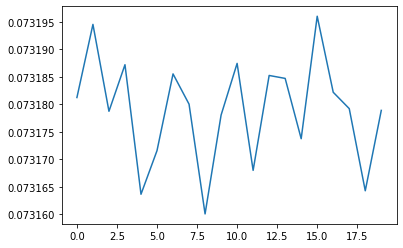

In [60]:
import matplotlib.pyplot as plt
plt.plot(history)

In [22]:
generate_sentence(rnn, '<sos>')

NameError: name 'generate_sentence' is not defined